## *Statistics coded:* Living conditions in Europe - income distribution and income inequality 

Prepared by [**Rodrigo González Santamaría**](rodrgo07@ucm.es) (EMOS).

This notebook aims at illustrating the *Statistics Explained* article on [Living conditions in Europe - income distribution and income inequality](https://ec.europa.eu/eurostat/statistics-explained/index.php?title=Living_conditions_in_Europe_-_income_distribution_and_income_inequality).


### Settings

Put all libraries/packages/modules/etc... that are necessary so that you can run this notebook.

In [2]:
from eurostatapiclient import EurostatAPIClient
import json
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.patches as mpatches
import matplotlib.pyplot as mplt
import matplotlib.dates as mdates
from matplotlib.ticker import FuncFormatter, MaxNLocator, IndexLocator
from shapely import geometry
import geopandas as gpd
import requests
import io, os, re, sys
import warnings
import copy, functools
import zipfile
import folium
from folium import plugins as foliump
import branca.colormap as bcm

legend_properties = {'weight':'bold','size':'12'}
countries_names = {'AT':'Austria', 'BE':'Belgium', 'BG':'Bulgaria', 'CY': 'Cyprus', 'CZ': 'Czechia', 'DE': 'Germany', 'DK':
            'Denmark', 'EE':'Estonia', 'EL': 'Greece', 'ES':'Spain', 'FI':'Finland', 'FR':'France', 'HR':'Croatia', 
            'HU':'Hungary', 'IE':'Ireland', 'IT':'Italy', 'LT':'Lithuania', 'LU':'Luxembourg', 'LV':'Latvia', 'MT':
            'Malta', 'NL':'Netherlands', 'PL':'Poland', 'PT':'Portugal', 'RO':'Romania', 'SE':'Sweden', 'SI':'Slovenia',
            'SK':'Slovakia', 'UK':'United Kingdom', 'EU28': 'EU-28'}
countries_abbr = ['AT','BE','BG','CY','CZ','DE','DK','EE','EL','ES','FI',
                  'FR','HR','HU','IE','IT','LT','LU','LV','NV','NL','PL','PT','RO','SE','SI','SK','UK','MT', 'EU28']

In [3]:
#Set versions and formats, so far only the ones used here are availeable and call client
VERSION = 'v2.1'
FORMAT = 'json'
LANGUAGE = 'en'
client = EurostatAPIClient(VERSION, FORMAT, LANGUAGE)

In [4]:
# We save the direc
_THISDIR_ = !pwd
print('Current working directory: %s' % _THISDIR_)

Current working directory: ['/home/rodrigo/Documentos/GitHub/statistics-coded/popul/living_conditions_income_distribution_and_income_inequality']


### General overview
- **Key Findings**
- **Income distribution**
- **Income inequality**


### Documentation

### Setting Map

In [5]:
# Graph the shape of Europe
# We first select the projection that will be used in this graph
PROJ = 'EPSG:4326'

In [6]:
# We can then integrate the NUTS data [https://nbviewer.jupyter.org/github/eurostat/mortality-viz/blob/master/02_mortality_european_regions.ipynb]
GISCO_DOMAIN = 'https://gisco-services.ec.europa.eu/distribution/v2/'
NUTS_DOMAIN = 'nuts'

NUTS_YEAR = 2021
NUTS_RES = 20 # 60
NUTS_PROJ = PROJ.split(':')[-1] 
NUTS_FMT = 'geojson' # 'topojson'

nuts_template = 'NUTS_RG_%sM_%s_%s_LEVL_%%s.%s' % (NUTS_RES, NUTS_YEAR, NUTS_PROJ, NUTS_FMT) 
nuts_url = '%s/%s/%s' %  (GISCO_DOMAIN, NUTS_DOMAIN, NUTS_FMT)

# https://gisco-services.ec.europa.eu/distribution/v2/nuts/geojson/NUTS_RG_20M_2021_3857_LEVL_1.geojson
#    'NUTS_RG_%sM_%s_3035_LEVL_%s.%s'

print("Generic URL for NUTS data: \033[1m%s/%s\033[0m (where '%%s' represents a level)" 
      % (nuts_url, nuts_template))

Generic URL for NUTS data: https://gisco-services.ec.europa.eu/distribution/v2//nuts/geojson/NUTS_RG_20M_2021_4326_LEVL_%s.geojson (where '%s' represents a level)


In [7]:
# We download the different NUTS data (hay cuatro niveles, cada uno de ellos corresponde a una division territorial)

LEVELS = [0,1,2,3]

nuts_files = dict.fromkeys(LEVELS)
nuts_ext = NUTS_FMT

for level in LEVELS:
    nuts_file = nuts_template % level
    nuts_source = '%s/%s' % (nuts_url,nuts_file)
    try : 
        dest = os.path.join(_THISDIR_[0], nuts_file)
        assert os.path.exists(dest)
    except:
        try:
            !wget -O $dest "$nuts_source"
            #!mkdir $nuts_dir
            #!unzip -u -d $nuts_dir $nuts_source        
        except:
            raise IOError("Error fetching the data...")
        else:
            print('Data loaded on disk in directory: \033[1m%s\033[0m' % dest)
    else:
        print('Data already loaded on disk in directory: \033[1m%s\033[0m' % dest)
    finally:
        nuts_files.update({level: nuts_file}) # dest

Data already loaded on disk in directory: /home/rodrigo/Documentos/GitHub/statistics-coded/popul/living_conditions_income_distribution_and_income_inequality/NUTS_RG_20M_2021_4326_LEVL_0.geojson
Data already loaded on disk in directory: /home/rodrigo/Documentos/GitHub/statistics-coded/popul/living_conditions_income_distribution_and_income_inequality/NUTS_RG_20M_2021_4326_LEVL_1.geojson
Data already loaded on disk in directory: /home/rodrigo/Documentos/GitHub/statistics-coded/popul/living_conditions_income_distribution_and_income_inequality/NUTS_RG_20M_2021_4326_LEVL_2.geojson
Data already loaded on disk in directory: /home/rodrigo/Documentos/GitHub/statistics-coded/popul/living_conditions_income_distribution_and_income_inequality/NUTS_RG_20M_2021_4326_LEVL_3.geojson


In [12]:
# We 'store' one vector dataset per NUTS level (nuts_data)

DRIVERS = {'geojson': 'GeoJSON',
          'shp': 'ESRI Shapefile'}

nuts_data = dict.fromkeys(LEVELS)
[nuts_data.update({l: gpd.read_file(os.path.join(_THISDIR_[0], nuts_files[l]), 
                                    driver=DRIVERS[NUTS_FMT])}) 
 for l in LEVELS]

print("Geographical datasets: \033[1m%s\033[0m loaded" % list(nuts_files.values()))
print("Projection: \033[1m%s\033[0m" % nuts_data[LEVELS[0]].crs)

Geographical datasets: ['NUTS_RG_20M_2021_4326_LEVL_0.geojson', 'NUTS_RG_20M_2021_4326_LEVL_1.geojson', 'NUTS_RG_20M_2021_4326_LEVL_2.geojson', 'NUTS_RG_20M_2021_4326_LEVL_3.geojson'] loaded
Projection: epsg:4326


In [ ]:
# Map of NUTS data (sin visualizar datos)
level = LEVELS[0]

f, ax = mplt.subplots(1, figsize=(16, 16))
nuts_data[level].plot(ax=ax)
ax.axes.get_xaxis().set_visible(False); ax.axes.get_yaxis().set_visible(False)
ax.set_title("NUTS at level %s (projection 'EPSG:%s')" % (level,NUTS_PROJ)) 
f.tight_layout()
mplt.show()

### Key findings

*Ibid*, the code here will help reproducing the material presented in the section [Key findings](https://ec.europa.eu/eurostat/statistics-explained/index.php?title=Living_conditions_in_Europe_-_poverty_and_social_exclusion#Key_findings).

### Income distribution

*Ibid*, the code here will help reproducing the material presented in the section [Income distribution](https://ec.europa.eu/eurostat/statistics-explained/index.php?title=Living_conditions_in_Europe_-_income_distribution_and_income_inequality#Income_distribution).

**Map-1 Median equivalised disposable income in the EU-27**

In [8]:
# We define query of dataframes from Eurostat query builder

dataset_map1_query = 'ilc_di03?precision=1&sex=T&indic_il=MED_E&geo=AT&geo=BE&geo=BG&geo=CH&geo=CY&geo=CZ&geo=DE&geo=DK&geo=EE&geo=EL&geo=ES&geo=EU27_2020&geo=FI&geo=FR&geo=HR&geo=HU&geo=IE&geo=IS&geo=IT&geo=LT&geo=LU&geo=LV&geo=ME&geo=MK&geo=MT&geo=NL&geo=NO&geo=PL&geo=PT&geo=RO&geo=RS&geo=SE&geo=SI&geo=SK&geo=TR&geo=UK&unit=PPS&time=2018&age=TOTAL'

# We use this query to retriev the data from the API Client
dataset_map1 = client.get_dataset(dataset_map1_query).to_dataframe().sort_values(by = ['values'],ascending = False)

# Simplify the dataset and change 
dataset_map1 = dataset_map1[['geo','values']]
dataset_map1.rename(columns=lambda x: x.strip(), inplace=True)


In [10]:
print('Dimensions of the table: %s' % list(dataset_map1.shape))
dataset_map1.head(5)

Dimensions of the table: [36, 2]


,geo,values
20,LU,32158.0
3,CH,27066.0
26,NO,26300.0
0,AT,23204.0
6,DE,21980.0


In [14]:
# Check which data/countries (DATA_NUTS_ID) are actually made available throughout the dataset
KEY = 'NUTS_ID'

NUTS_ID = dict.fromkeys(LEVELS)
CTRY_ID = dict.fromkeys(LEVELS) 

for l in LEVELS:
    NUTS_ID.update({l: nuts_data[l][KEY].unique().tolist()})
    CTRY_ID.update({l: list(set([_id[:2] for _id in NUTS_ID[l]]))})
    
DATA_NUTS_ID = dict.fromkeys(LEVELS) 
all_id = dataset_map1['geo'].unique().tolist()

print('Data are availalble:') 
for l in LEVELS:
    DATA_NUTS_ID.update({l: list(set([_id[:2] for _id in all_id if len(_id)==l+2]))})
    print('* NUTS level %s: \033[1m%s\033[0m' 
          % (l, DATA_NUTS_ID[l]))

Data are availalble:
* NUTS level 0: ['UK', 'RO', 'NO', 'CY', 'FI', 'LT', 'FR', 'BE', 'LV', 'PT', 'AT', 'NL', 'BG', 'HR', 'SK', 'MK', 'IE', 'PL', 'SI', 'CZ', 'CH', 'IT', 'HU', 'DK', 'IS', 'ME', 'ES', 'RS', 'TR', 'LU', 'EE', 'SE', 'MT', 'EL', 'DE']
* NUTS level 1: []
* NUTS level 2: []
* NUTS level 3: []


In [15]:
# Check which country/datasets are missing
MISSING_CTRY_ID = dict.fromkeys(LEVELS) 

print('Data are NOT availalble:') 
for l in LEVELS:
    MISSING_CTRY_ID.update({l: list(set(CTRY_ID[l]).difference(set(DATA_NUTS_ID[l])))})
    print('* NUTS level %s: \033[1m%s\033[0m' 
          % (l, MISSING_CTRY_ID[l]))

Data are NOT availalble:
* NUTS level 0: ['AL', 'LI']
* NUTS level 1: ['UK', 'RO', 'NO', 'CY', 'FI', 'LT', 'FR', 'BE', 'LV', 'PT', 'AT', 'NL', 'BG', 'HR', 'SK', 'MK', 'IE', 'PL', 'SI', 'CZ', 'CH', 'IT', 'HU', 'LI', 'DK', 'IS', 'ME', 'ES', 'RS', 'AL', 'TR', 'EE', 'LU', 'EL', 'MT', 'SE', 'DE']
* NUTS level 2: ['UK', 'RO', 'NO', 'CY', 'FI', 'LT', 'FR', 'BE', 'LV', 'PT', 'AT', 'NL', 'BG', 'HR', 'SK', 'MK', 'IE', 'PL', 'SI', 'CZ', 'CH', 'IT', 'HU', 'LI', 'DK', 'IS', 'ME', 'ES', 'AL', 'TR', 'RS', 'EE', 'LU', 'MT', 'EL', 'SE', 'DE']
* NUTS level 3: ['UK', 'RO', 'NO', 'CY', 'FI', 'LT', 'FR', 'BE', 'LV', 'PT', 'AT', 'NL', 'BG', 'HR', 'SK', 'MK', 'IE', 'PL', 'SI', 'CZ', 'CH', 'IT', 'HU', 'LI', 'DK', 'IS', 'ME', 'ES', 'AL', 'RS', 'TR', 'EE', 'LU', 'EL', 'SE', 'MT', 'DE']


In [17]:
# Prepare dataframe to merge the NUTS DATA
dataset_map1.rename(columns = {'geo':'NUTS_ID'}, inplace = True)
dataset_map1.head(n = 5)

,NUTS_ID,values
20,LU,32158.0
3,CH,27066.0
26,NO,26300.0
0,AT,23204.0
6,DE,21980.0


In [18]:
# We merge NUTS_Data and Dataset_map1
country_data = nuts_data[LEVELS[0]]

# Merge on NUTS_ID
income_nuts = pd.merge(country_data, dataset_map1, how = 'inner', on = 'NUTS_ID') 
income_nuts.head()

,id,COAST_TYPE,MOUNT_TYPE,NAME_LATN,CNTR_CODE,FID,NUTS_ID,NUTS_NAME,LEVL_CODE,URBN_TYPE,geometry,values
0,FR,None,None,France,FR,FR,FR,France,0,None,"(POLYGON ((2.54601 51.08938, 2.57769 51.00052,...",20223.0
1,HR,None,None,Hrvatska,HR,HR,HR,Hrvatska,0,None,"(POLYGON ((16.59681 46.4759, 16.85476 46.35044...",9870.0
2,HU,None,None,Magyarország,HU,HU,HU,Magyarország,0,None,"POLYGON ((22.12108 48.37831, 22.15531 48.4034,...",8603.0
3,AT,None,None,Österreich,AT,AT,AT,Österreich,0,None,"POLYGON ((15.75363 48.85218, 16.29009 48.73395...",23204.0
4,BE,None,None,Belgique/België,BE,BE,BE,Belgique/België,0,None,"POLYGON ((4.75993 51.50246, 4.864 51.43362, 5....",21353.0


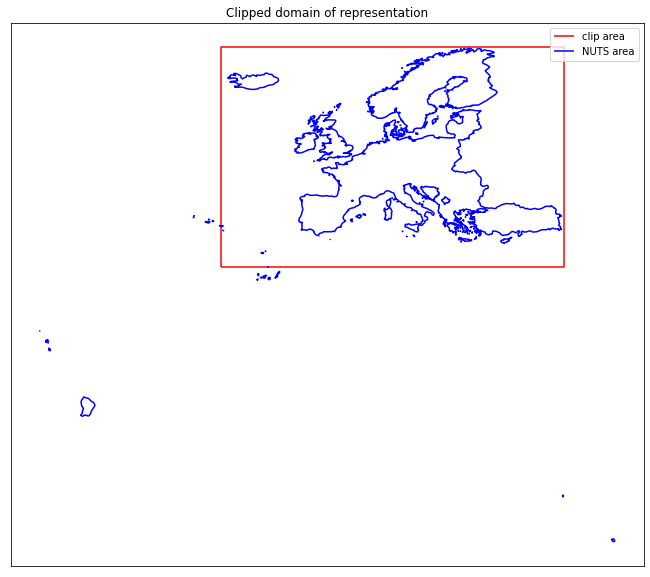

In [19]:
# We define a very coarse bounding box that is embedded in the NUTS bounding box (NUTSarea) so as to render the data in a smaller region
EUmask = geometry.Polygon([#w: -25.5, s:35, e:30.2, n:71.3 in EPSG:4326 system
                         (-25.5, 30.2),
                         (45.3,  30.2),
                         (45.3,  71.3),
                         (-25.5, 71.3)
])
EUclip = gpd.GeoDataFrame(index=[0], geometry=[EUmask], crs=PROJ)

NUTSarea = gpd.GeoDataFrame(index=[0], geometry=[nuts_data[0].unary_union], crs=PROJ)


f, ax = mplt.subplots(1, figsize=(16, 10))
EUclip.boundary.plot(ax=ax, color='r', label='clip area')
NUTSarea.boundary.plot(ax=ax, color='b', label='NUTS area')
ax.axes.get_xaxis().set_visible(False); ax.axes.get_yaxis().set_visible(False)
ax.set_title('Clipped domain of representation')
ax.legend()
mplt.show()

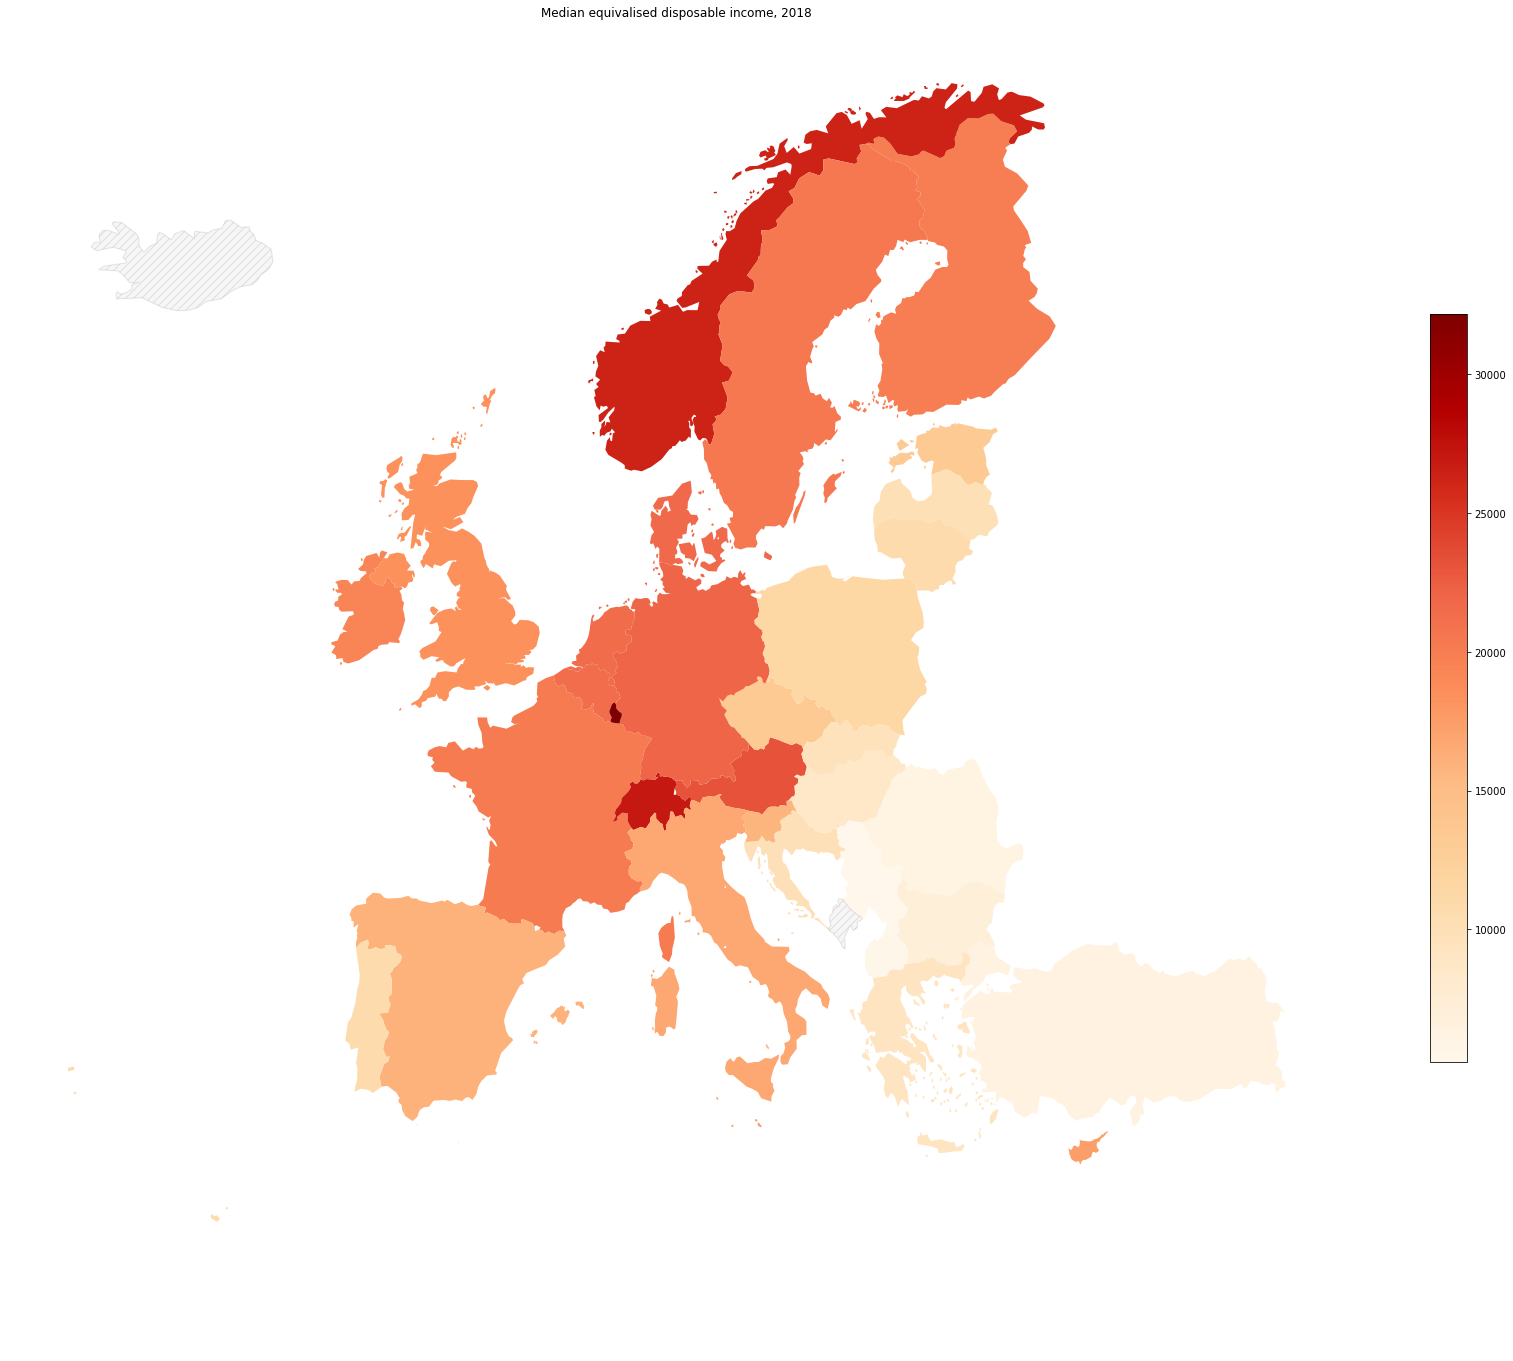

In [23]:
LEVEL = 0
crop = gpd.clip(income_nuts, EUclip)
# crop = nuts_death_data[LEVEL].intersection(EUclip.unary_union) 

f, ax = mplt.subplots(1, figsize=(30, 25))
crop.plot(column='values', ax=ax, cmap='OrRd', legend=True,
          legend_kwds = {'shrink':0.55},
          missing_kwds={ "color": "lightgrey", "alpha": 0.2, "edgecolor": "grey", "hatch": "///"}
         )
ax.set_axis_off()
ax.set_title('Median equivalised disposable income, 2018')
# f.tight_layout()
#f.subplots_adjust(hspace=0,wspace=-1)
mplt.show()

### Income inequality

*Ibid*, the code here will help reproducing the material presented in the section [Income inequality](https://ec.europa.eu/eurostat/statistics-explained/index.php?title=Living_conditions_in_Europe_-_income_distribution_and_income_inequality#Income_inequality).